### Detecting phishing attempts in emails

#### Keywords: XGBoost, Keras, Tensorflow, Feature Importance, AUROC, Precision-Recall, and other model evaluations

Classifying phishing attempts using XGBoost and Keras deep learning framework. Evaluation of each model performance. 

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [121]:
data = pd.read_csv('dataset.csv')

In [122]:
data.Result.value_counts()

 1    6157
-1    4898
Name: Result, dtype: int64

In [123]:
#Convert Target to 0
data.loc[data.Result == -1, ["Result"]] = 0

In [124]:
data.head()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,0
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,0
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,0
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,0
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [125]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

t1 = 'Result'
SEED = 1233

def traintestsplit(dat):
    #sub_data, Hold_out = down_sampling()
    transform_columns = dat.iloc[:].columns

    ###### ######
    scaler = MinMaxScaler()
    scaler.fit(dat[transform_columns])
    dat[transform_columns] = scaler.transform(np.float32(dat[transform_columns]))

    X_train, X_validation = train_test_split(dat, test_size=0.25, random_state = SEED)
    # assign the training target varible
    y_train = (X_train[[t1]])              
    # remove the target from the x_trainig set
    X_train = X_train.drop([t1], axis=1)   

    y_validation = (X_validation[[t1]])             ## target to test model with
    X_validation = X_validation.drop([t1], axis=1)  ## x_testing set
    
    
    return X_train, X_validation, y_train, y_validation

In [137]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def main_xgb(dat):
    for i in range(1):
        """ import data, split into train/test sets -> fit Xgbm model, run analysis + metrics"""
        
        #split data function 
        X_train, X_validation, y_train, y_validation = traintestsplit(dat)
        
        X = np.array(X_train)
        y = np.array(y_train)

        # using generic XGBm classifier from XGBoost
        xbmodel = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
                    gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
                    min_child_weight=8, missing=None, n_estimators=125, nthread=-1,
                    objective='binary:logistic', reg_alpha=0, reg_lambda=1,
                    scale_pos_weight=1, seed=SEED, silent=True, subsample=1)
        
        #fit the model...
        xbmodel.fit(X, y) 

        #Using feature importance
        print("Feature Importance: ")
        sorted_idx = np.argsort(xbmodel.feature_importances_)[::-1]
        for index in sorted_idx[1:10]:
            print([X_train.columns[index], xbmodel.feature_importances_[index]]) 
        print("\n")
        
        #######################   
        # Look at analysis 
        X = np.array(X_validation)
        y = np.array(y_validation)

        pred_y = xbmodel.predict(X) #Predict on the model
        cnf_matrix = confusion_matrix(y, pred_y)
        class_report = classification_report(y, pred_y)
        
        print("Confusion Matrix")
        print(confusion_matrix(y, pred_y))
        print(classification_report(y,pred_y))
        
        accuracy = 0
        for j in range(len(cnf_matrix)):
            accuracy += cnf_matrix[j][j]
        print("Acc:" , float(accuracy) / float(len(y)))



        y_pred_proba = xbmodel.predict_proba(X)

        #Matt Coef
        mcc = metrics.matthews_corrcoef(y, pred_y)

        #precision, recall, thresh = metrics.precision_recall_curve(y, y_pred_proba)
        precision, recall, thresh = metrics.precision_recall_curve(y, y_pred_proba[:,1])
        pr_area = metrics.auc(recall, precision)

        #scores
        roc_auc_sc = metrics.roc_auc_score(y, y_pred_proba[:,1])
        precision_sc = metrics.precision_score(y, pred_y)
        recall_sc = metrics.recall_score(y, pred_y)
        f1_sc = metrics.f1_score(y, pred_y)

        #######################
        # Metrics for AUROC plot
        fpr, tpr, thresh_rc = metrics.roc_curve(y, y_pred_proba[:,1])

        lab = 'ROC AUC={:0.3f}'.format(roc_auc_sc)

        plt.plot(fpr, tpr, label=lab)
        plt.plot([0, 1], [0, 1],'r--') #identity
        plt.xlabel('False Positive Rate (1-Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.title('Receiver Operating Characteristic Curve')
        plt.show() 
        
        ########################
        # Precision Recall Plot
        average_precision = average_precision_score(y, y_pred_proba[:,1])

        print('Average precision-recall score: {0:0.2f}'.format(average_precision))
        print('Precision Score: {0:0.2f}'.format(precision_sc))
        
        precision_c, recall_c, _ = precision_recall_curve(y, y_pred_proba[:,1])
        #plotting Part
        plt.step(recall_c, precision_c, color='b', alpha=0.2, where='post')
        plt.fill_between(recall_c, precision_c, step='post', alpha=0.2,
                         color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
                  average_precision))
        
        
        
        #return X_train, X_validation, y_train, y_validation, X, y, xbmodel

### Run XGB Main

Feature Importance: 
['having_Sub_Domain', 0.076995306]
['web_traffic', 0.074178405]
['Links_in_tags', 0.064475745]
['SSLfinal_State', 0.05821596]
['Links_pointing_to_page', 0.05477308]
['Request_URL', 0.048200313]
['URL_of_Anchor', 0.047574334]
['having_IPhaving_IP_Address', 0.037245695]
['age_of_domain', 0.03192488]


Confusion Matrix
[[1165   40]
 [  58 1501]]
             precision    recall  f1-score   support

        0.0       0.95      0.97      0.96      1205
        1.0       0.97      0.96      0.97      1559

avg / total       0.96      0.96      0.96      2764

('Acc:', 0.9645441389290883)


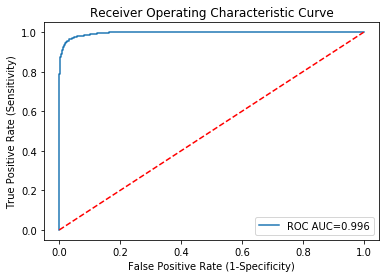

Average precision-recall score: 1.00
Precision Score: 0.97


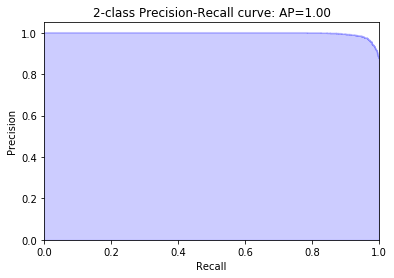

In [138]:
#Run the model
main_xgb(data)

In [139]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics

def main_NN(data):
    for i in range(1):

        X_train, X_validation, y_train, y_validation = traintestsplit(data)

        X = np.array(X_train)
        y = np.array(y_train)

        # using generic SGD params 
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

        NN_model = Sequential()  # create model with dropout layer
        NN_model.add(Dense(100, input_dim=X_validation.shape[1], activation='relu'))  # hidden layer
        NN_model.add(Dense(500, activation='relu'))
        NN_model.add(layers.Dropout(0.5))
        NN_model.add(Dense(500, activation='relu'))
        NN_model.add(Dense(1, activation='sigmoid', name='output'))  # output layer

        #Compile the neural network model
        NN_model.compile(loss='binary_crossentropy',
                          optimizer='sgd',
                          metrics=['accuracy']
                          )
        #fit the neural network
        NN_modeled = NN_model.fit(X_train, y_train, 
                      epochs=5, 
                      batch_size=32,
                      shuffle=True,
                      verbose=True,
                      #validation_split=0.30,
                      validation_data=(X_validation, y_validation))

        #Look at analysis 
        X = np.array(X_validation)
        y = np.array(y_validation)

        pred_y = NN_model.predict(X, verbose=0, batch_size=32)
        pred_y = [float(np.round(x)) for x in pred_y]
        
        cnf_matrix = confusion_matrix(y, pred_y)
        class_report = classification_report(y, pred_y)
        print("Confusion Matrix")
        print(confusion_matrix(y, pred_y))
        print(classification_report(y,pred_y))
        
        accuracy = 0
        for j in range(len(cnf_matrix)):
            accuracy += cnf_matrix[j][j]
        print("Acc:" , float(accuracy) / float(len(y)))

        y_pred_proba = NN_model.predict_proba(X)

        #Matt Coef
        mcc = metrics.matthews_corrcoef(y, pred_y)

        #precision, recall, thresh = metrics.precision_recall_curve(y, y_pred_proba)
        precision, recall, thresh = metrics.precision_recall_curve(y, y_pred_proba)
        pr_area = metrics.auc(recall, precision)

        #scores
        roc_auc_sc = metrics.roc_auc_score(y, y_pred_proba)
        precision_sc = metrics.precision_score(y, pred_y)
        recall_sc = metrics.recall_score(y, pred_y)
        f1_sc = metrics.f1_score(y, pred_y)

        fpr, tpr, thresh_rc = metrics.roc_curve(y, y_pred_proba)

        lab = 'ROC AUC={:0.3f}'.format(roc_auc_sc)

        plt.plot(fpr, tpr, label=lab)
        plt.plot([0, 1], [0, 1],'r--') #identity
        plt.xlabel('False Positive Rate (1-Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.title('Receiver Operating Characteristic Curve')
        plt.show()
        
        ########################
        # Precision Recall Plot
        average_precision = average_precision_score(y, y_pred_proba)

        print('Average precision-recall score: {0:0.2f}'.format(average_precision))
        print('Precision Score: {0:0.2f}'.format(precision_sc))
        
        precision_c, recall_c, _ = precision_recall_curve(y, y_pred_proba)
        #plotting Part
        plt.step(recall_c, precision_c, color='b', alpha=0.2, where='post')
        plt.fill_between(recall_c, precision_c, step='post', alpha=0.2,
                         color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
                  average_precision))

Train on 8291 samples, validate on 2764 samples
Epoch 1/5
8291/8291 [==============================] - 2s 190us/step - loss: 0.6195 - acc: 0.6623 - val_loss: 0.5024 - val_acc: 0.8470
Epoch 2/5
8291/8291 [==============================] - 1s 138us/step - loss: 0.4271 - acc: 0.8479 - val_loss: 0.2878 - val_acc: 0.9016
Epoch 3/5
8291/8291 [==============================] - 1s 138us/step - loss: 0.2947 - acc: 0.8922 - val_loss: 0.2210 - val_acc: 0.9190
Epoch 4/5
8291/8291 [==============================] - 1s 136us/step - loss: 0.2511 - acc: 0.9063 - val_loss: 0.2018 - val_acc: 0.9179
Epoch 5/5
8291/8291 [==============================] - 1s 131us/step - loss: 0.2360 - acc: 0.9122 - val_loss: 0.2895 - val_acc: 0.8806
Confusion Matrix
[[1166   39]
 [ 291 1268]]
             precision    recall  f1-score   support

        0.0       0.80      0.97      0.88      1205
        1.0       0.97      0.81      0.88      1559

avg / total       0.90      0.88      0.88      2764

('Acc:', 0.8806078

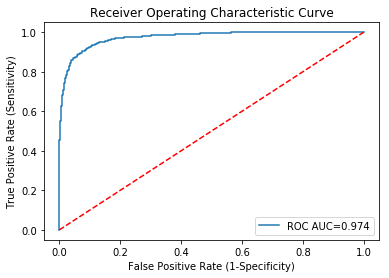

Average precision-recall score: 0.98
Precision Score: 0.97


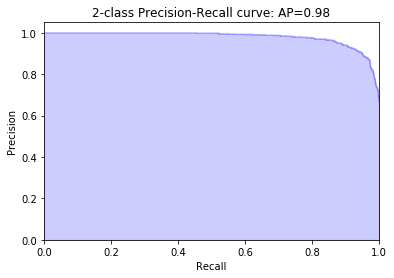

In [140]:
main_NN(data)